In [3]:
import multiprocessing as mp
from util.backtest import *
from util.factor_util import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
from time import sleep
import statsmodels.api as sm
import os
import seaborn as sns
import glob

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

In [21]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


df = pd.read_csv('/home/frank/document/Python/Factors/data/data_1h.csv')
df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

df = df.drop(['Volume','numberOfTrades'],axis= 1)
print('Dataframe prepared completed')

In [ ]:
categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()
for category in categories.keys():
    print(category,len(categories[category]))


token 113
coin 65
Ethereum 101
Solana-ecosystem 15
bnb-chain 43
Polkadot 17
defi 68
innovation 24
gaming 18
nft 33
infrastructure 16
layer1_layer2 35
pos 47
pow 20
all 206


In [ ]:
col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)
df_data['Open'] = df_data['Close'].shift(1)
print("Pivot table completed")

Pivot table completed


In [ ]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(7*24).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)


In [6]:
## Calc Data
formula_list = []
input_data_list = []

with open('/home/frank/document/Python/Factors/data/formulas/all_formula_list_20230221.csv','r') as f:
    formula_list += f.read().split('\n')

with open('/home/frank/document/Python/Factors/data/data_list/all_data_list_20230221.csv','r') as f:
    input_data_list += f.read().split('\n')

In [7]:
input_data_list[0]

'Close'

In [8]:
import glob
files = glob.glob('/home/frank/document/Python/Factors/output/hypertune/level1/*/*.csv')
files = [file for file in files if 'Ensamble' in file and 'nav' not in file]
files[:5]

['/home/frank/document/Python/Factors/output/hypertune/level1/5534/Ensamble_5534.csv',
 '/home/frank/document/Python/Factors/output/hypertune/level1/9014/Ensamble_9014.csv',
 '/home/frank/document/Python/Factors/output/hypertune/level1/21654/Ensamble_21654.csv',
 '/home/frank/document/Python/Factors/output/hypertune/level1/19441/Ensamble_19441.csv',
 '/home/frank/document/Python/Factors/output/hypertune/level1/961/Ensamble_961.csv']

In [9]:
ls = []
for file in files:
    df = pd.read_csv(file,index_col=0)
    if df['Ann. Sharpe'].min()>1.:
        df['strategy'] = file.split('/')[-2]
        ls.append(df.sort_values(['FitnessValue','Ann. Sharpe'],ascending = False).iloc[:5])
df = pd.concat(ls)
df.sort_values(['ATH_Score','Ann. Sharpe'],ascending = False).drop_duplicates('strategy')

,vol_len,len1,len2,len3,Ann. Return(%),MDD(%),Ret/Mdd,Ann. Sharpe,ATH_Score,Monthly_Return_Score,Cummax_Score,FitnessValue,Sharpe Decay,strategy
2929,168,424,584,336.0,127.031609,29.925089,4.244987,2.289224,0.253078,0.666667,0.386523,1.3,1.0,1434
509,72,536,592,520.0,109.081429,47.668683,2.288325,1.583928,0.217510,0.625000,0.345193,0.8,1.0,14467
1970,168,592,672,672.0,99.896295,27.927937,3.576931,1.248729,0.213406,0.541667,0.260198,0.5,2.0,6957
2946,720,448,544,NaN,112.731498,25.365523,4.444280,1.873068,0.207934,0.666667,0.383468,1.0,0.0,8238
179,168,480,496,432.0,77.515855,24.422142,3.173999,1.292489,0.206566,0.583333,0.249955,0.5,1.0,4690
206,720,288,256,264.0,107.582751,48.735637,2.207476,1.512364,0.192886,0.666667,0.323810,0.7,1.0,16507
1956,168,544,536,544.0,103.977335,39.481822,2.633550,1.406143,0.190150,0.541667,0.377898,0.8,0.0,3686
1314,720,152,312,320.0,108.364175,31.078497,3.486789,1.786788,0.188782,0.708333,0.477987,1.2,2.0,14318
896,168,256,88,288.0,124.951301,34.883658,3.581944,2.012760,0.187415,0.583333,0.375382,1.1,0.0,11886
1280,336,344,224,448.0,122.855851,36.097846,3.403412,1.741379,0.168263,0.625000,0.385445,0.9,3.0,18525


In [10]:
df.strategy.unique().shape

(16,)

In [11]:
file.split('/')[-2]

'12551'

In [155]:
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics.csv')
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics2.csv',dtype = {'Strategy':str})
# metrics.Strategy = metrics.Strategy.apply(lambda x:input_data_list[int(x.split('.')[0])] +'.' + formula_list[int(x.split('.')[1])])#level2
metrics = metrics.set_index('Strategy')
# metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/backtest_metrics_20230221.csv',index_col = 0)
print(metrics.shape)
metrics = metrics.sort_index().drop_duplicates('Sharpe').sort_values('Fitnessvalue',ascending = False)
# metrics = metrics[metrics['Insample Sharpe']> metrics['Outsample Sharpe']*0.75]
metrics = metrics[metrics['Sharpe'] != metrics['Fitnessvalue']]
# metrics = metrics[metrics['Sharpe'] >=1]
# metrics = metrics[metrics['Outsample Sharpe'] >=1]

# metrics = metrics[(metrics['Long Fitness'] >= 0) & (metrics['Short Fitness'] >= 0)]
metrics
print(metrics.shape)
# print(metrics.sort_values('Fitnessvalue',ascending = False).index[:20])
metrics.sort_values('Fitnessvalue',ascending = False).head()#.shape


(22809, 28)
(22426, 28)


,Sharpe,Fitnessvalue,turnover,winlossratio,IC,IR,Rank_IC,Rank_IR,Insample Sharpe,Outsample Sharpe,...,IS_turnover,OS_turnover,IS_IC,IS_IR,OS_IC,OS_IR,IS_Rank_IC,IS_Rank_IR,OS_Rank_IC,OS_Rank_IR
Strategy,,,,,,,,,,,,,,,,,,,,,
Open/Low.Kurt.Sign.Quantile25,1.941420,3.219881,0.000312,6.266713,0.030739,0.459876,0.029547,0.400161,1.994403,0.000000,...,0.000428,0.000000,0.031112,0.387777,NaN,NaN,0.031112,0.388847,NaN,NaN
High/Low.Kurt.Sign.Quantile25,1.502883,2.492559,0.000000,3.438495,0.029401,0.131069,0.024507,0.283813,1.763012,0.000000,...,0.000000,0.000000,0.029401,0.295638,NaN,NaN,0.029401,0.295638,NaN,NaN
Open/Low.Rank,2.852353,2.332715,1.237993,1.229169,0.014851,0.094413,0.016606,0.099874,3.374466,2.329504,...,1.223034,1.276068,0.018548,0.092328,0.002862,0.021333,0.024708,0.128304,-0.001232,-0.010424
Open/Low.Kurt.Sign.Quantile50,1.218758,2.021334,0.000525,8.545651,0.073347,0.585937,0.073347,0.874251,1.429142,0.000000,...,0.000721,0.000000,0.073347,0.874251,NaN,NaN,0.073347,0.874251,NaN,NaN
High.Skew.Min.Skew,2.477659,1.774375,0.574140,1.256641,0.003638,0.064480,0.009816,0.061450,2.520230,1.211063,...,0.568511,0.595546,0.006640,0.035563,-0.009873,-0.093837,0.020440,0.107117,0.002261,0.023088


##  Selected

In [65]:
strategies = {
    'Open/Close.SignedPower.Abs.Kurt_Reverse':[
        # [24,488],
        [72,400,],
        [72,488],
        [24,416],
    ],
    'High/Close.Pct_Change.Max.Skew_Reverse':[
        [72,152,112,444],
        [168,24,48,372],
        # [168,40,136,340],
        [168,96,72,324],
        # [24,48,72,372],
        [24,128,120,428],
    ],
    'Close.Pct_Change':[[168,168]],


}

In [7]:


stress_score = {}

category = 'all'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])




In [11]:
h1_ret = df_data['Close'].diff()

In [66]:
results = {}
tmp_result = {}
for name,params in strategies.items():

    for param in params:
        market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
        volume = df_data['quoteAssetVolume'].sort_index().rolling(param[0]).sum().fillna(0)
        volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
        GLOBAL_FILTER = market_filter & (volume_filter>0.5)
        GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

        print(name,param)
        data = name.replace('_Reverse','').split('.')
        formula = '.'.join(data[1:])
        data = data[0]

        factor = calc_factors(calc_input_data(df_data,data),formula,params = param[1:])#[168,72,208,528]
        # factor = df_data['Open']/df_data['Close'] - 1
        # factor = factor.pow(2) * factor.apply(lambda x: np.sign(x))
        # factor = factor.rolling(424).kurt()
        factor = factor.sort_index().resample(FREQ).last()
        cond = GLOBAL_FILTER


        selected = 5



        rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
        
        select = rk.max(axis = 1) * selected * 0.01
        select = select.apply(lambda x:max(np.floor(x),3))

        long_signal = rk.copy()
        long_signal[:] = 0
        short_signal = long_signal.copy()

        # long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) & (df_data['Close'].pct_change()>0)] = 1 
        # short_signal[rk.le(select,axis = 0) & (df_data['Close'].pct_change()<0)] = -1 

        long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) ] = 1 
        short_signal[rk.le(select,axis = 0) ] = -1 

        # signal = (long_signal + short_signal).reindex(df_data['Close'].index).ffill().fillna(0)
        
        FEE = 4
        long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
        short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)

        result = ((long_result + short_result)/2).sum(axis = 1)



        # size = 10**4/select/2 # / close * long_signal
        # size = 1/df_data['Close'].div(size,axis = 0) * (long_signal + short_signal)# * close


        tmp_result[f'{name}_{param}'] = result.copy()
    
    results[f'{name}'] = pd.DataFrame(tmp_result).mean(axis = 1)
    # break
    # break


Open/Close.SignedPower.Abs.Kurt_Reverse [24, 488]
Open/Close.SignedPower.Abs.Kurt_Reverse [72, 400]
Open/Close.SignedPower.Abs.Kurt_Reverse [24, 416]
High/Close.Pct_Change.Max.Skew_Reverse [72, 152, 112, 444]


/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


High/Close.Pct_Change.Max.Skew_Reverse [168, 24, 48, 372]
High/Close.Pct_Change.Max.Skew_Reverse [168, 96, 72, 324]
High/Close.Pct_Change.Max.Skew_Reverse [24, 48, 72, 372]
Close.Pct_Change [168, 168]


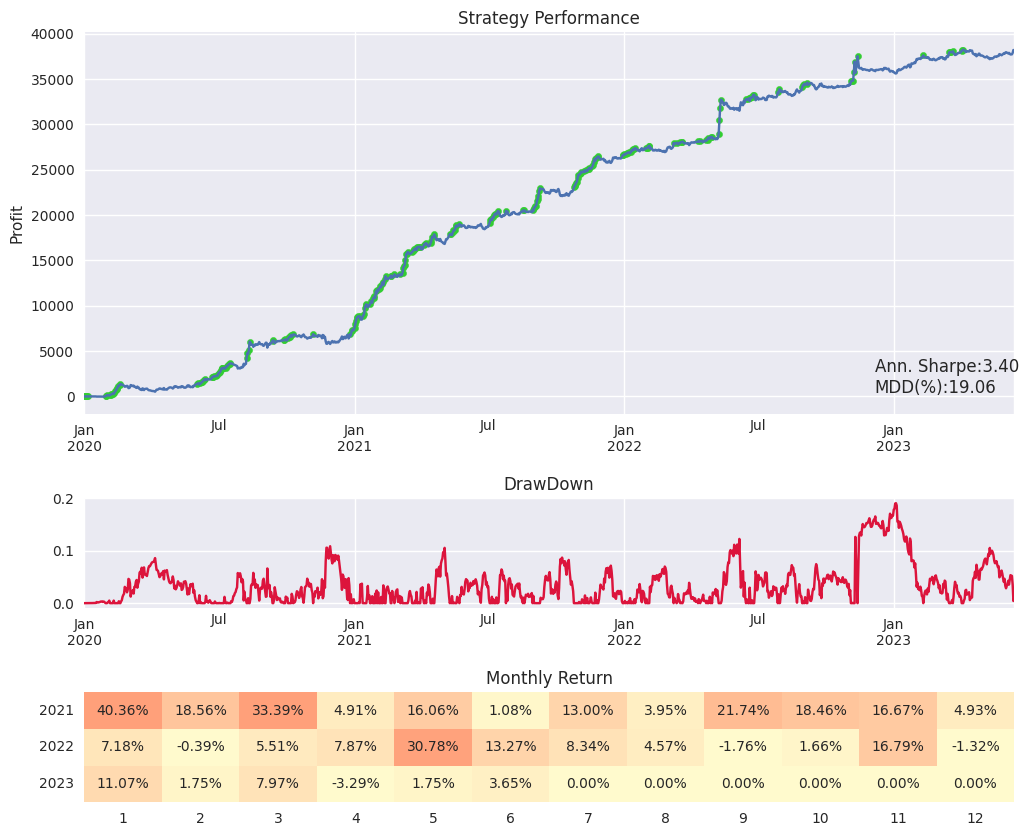

In [67]:
tmp = pd.DataFrame(tmp_result)
show_return(tmp[tmp.columns[:]].mean(axis = 1).loc[datetime(2020,1,1):])


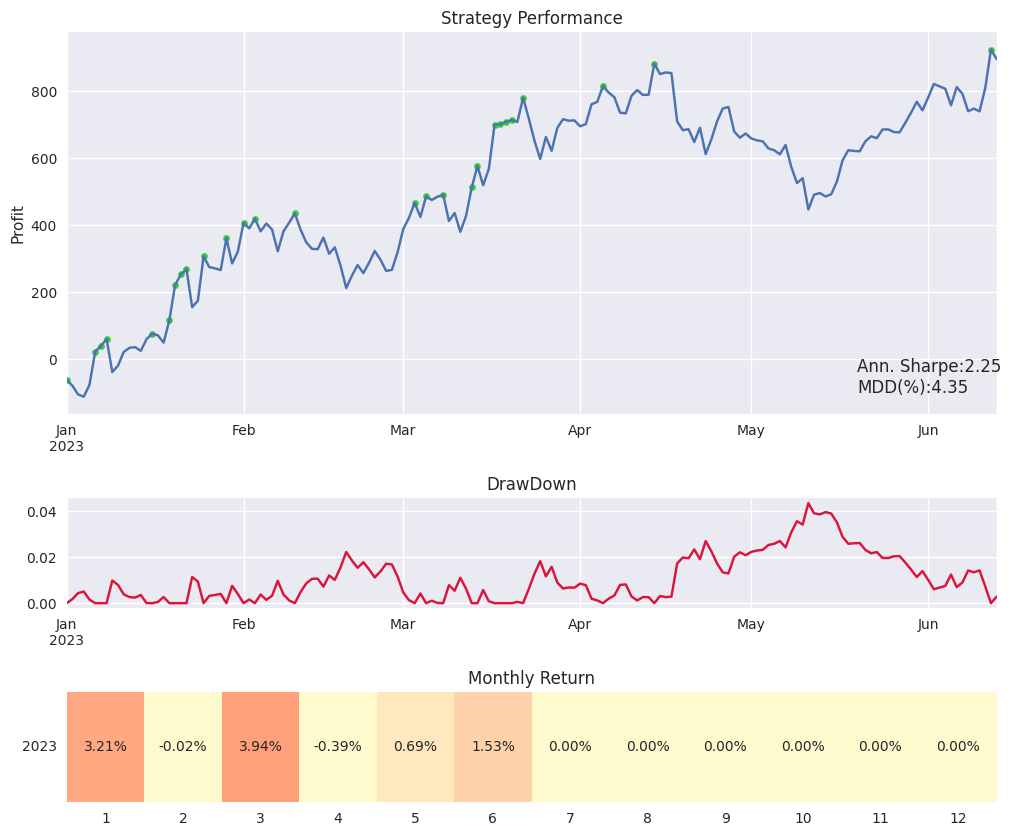

In [47]:
show_return((pd.DataFrame(results) * [0.4,0.6,0.2]).mean(axis = 1).loc[datetime(2023,1,1):])


<AxesSubplot:xlabel='openTime'>

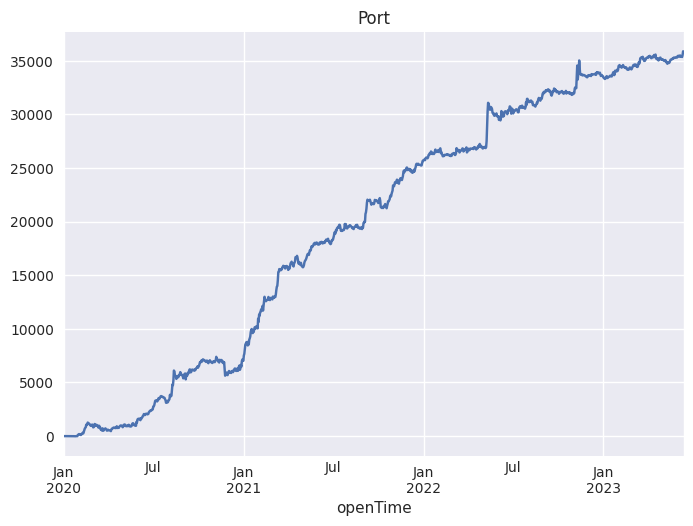

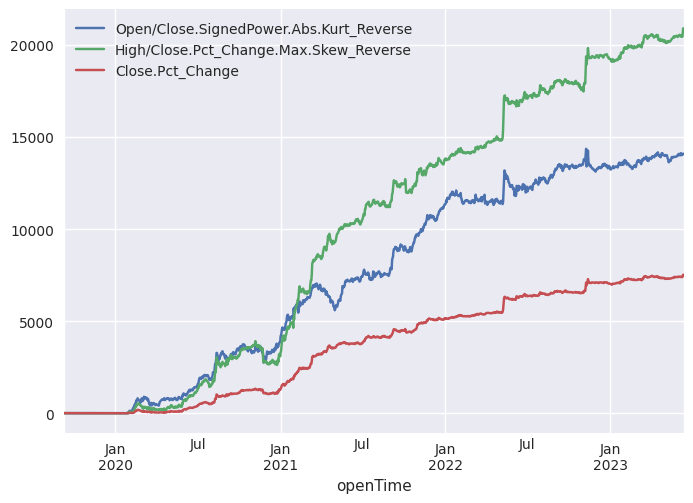

In [14]:
port = (pd.DataFrame(results) ).mean(axis = 1)
port.loc[datetime(2020,1,1):].cumsum().plot(title = 'Port')
# pd.DataFrame(results).cumsum().plot()
(pd.DataFrame(results) * [0.4,0.6,0.2]).cumsum().plot()
# result

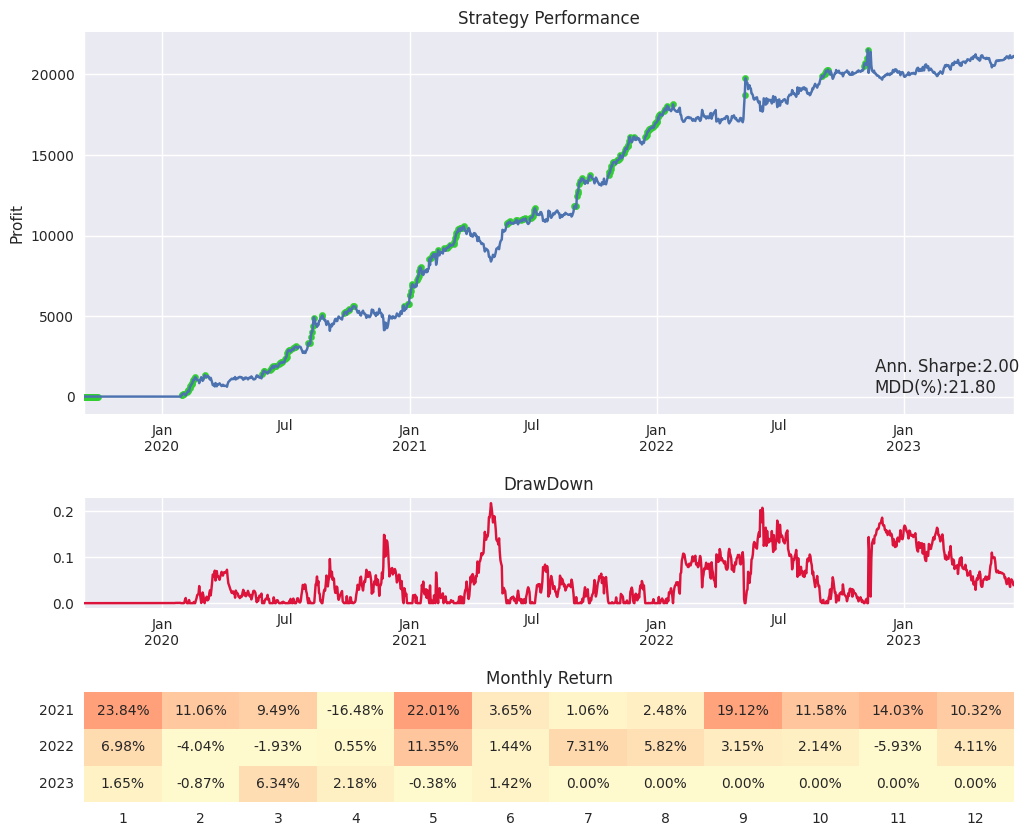

In [15]:
# pd.DataFrame(results)['Open/Close.SignedPower.Abs.Kurt_Reverse']
show_return(pd.DataFrame(results)[['Open/Close.SignedPower.Abs.Kurt_Reverse']].mean(axis=  1) * 0.6)

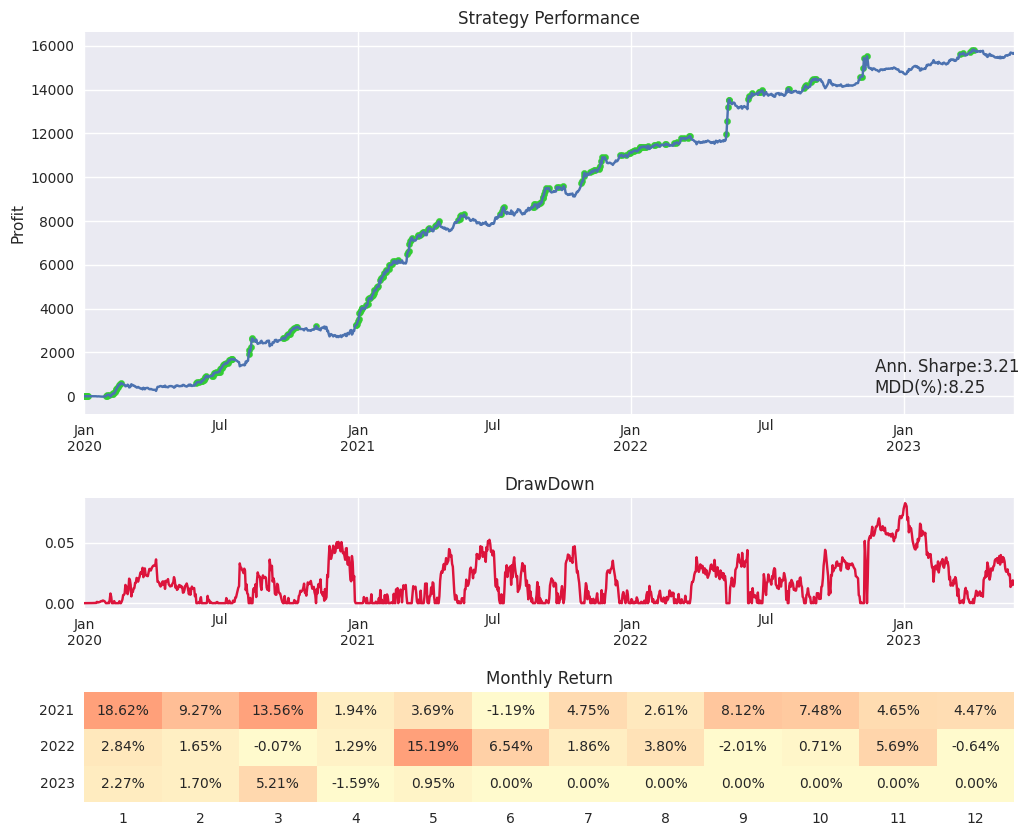

In [106]:
show_return(port.loc[datetime(2020,1,1):])
# pd.DataFrame(results).loc[datetime(2021,5,8):].cumsum().plot()

In [25]:
def show_return(result,bm = None,bm_name = 'CryptoMarket',figsize= (14,10),show_bm = False):

    fig = plt.figure(figsize=(12,10),constrained_layout=False)
    gs = fig.add_gridspec(20, 20)

    ax = fig.add_subplot(gs[:10, :])
    ax = result.cumsum().plot(ax = ax,title = 'Strategy Performance')
    result.cumsum()[result.cumsum()==result.cumsum().cummax()].reset_index().rename({0:'Profit'},axis = 1).plot.scatter(ax = ax,x=result.index.name,y='Profit',color= 'limegreen')

    if show_bm:
        ax2 = ax.twinx()
        bm = crawl_cmcIndex().pct_change().loc[result.index[0]:result.index[-1]]
        bm.add(1).cumprod().plot(ax = ax2)

    
    
    # plt.axvline(x=SAMPLE_END_DATE,c='firebrick',alpha= 0.5,ls = '--')
    # plt.axvline(x=VALID_END_DATE,c='silver',alpha= 0.7,ls = '--')
    # plt.axvline(x=INSAMPLE_END_DATE,c='silver',alpha= 0.5,ls = '--')

    # ax = fig.add_subplot(gs[:10, 10:])

    performance_metrics = show_performance_metrics(result,show = False)
    content = ''
    content += 'Ann. Sharpe:%.2f\n'%(performance_metrics['Ann. Sharpe'])
    content += 'Ann. Ret/Mdd:%.2f\n'%(performance_metrics['Ret/Mdd'])
    content += 'Ann. Return(%%):%.2f\n'%(performance_metrics['Ann. Return(%)'])
    content += 'MDD(%%):%.2f\n'%(performance_metrics['MDD(%)'])

    ax.text(0.85,0., content,
            verticalalignment='baseline',
            fontsize = 'large',
            transform=ax.transAxes)
    ax.set_xlabel('')


    ax = fig.add_subplot(gs[12:15, :])
    DD = result.cumsum().cummax()-result.cumsum()
    DD /= 10**4
    DD.plot(ax = ax,title = 'DrawDown',color=  'crimson')
    ax.set_xlabel('')

    ax = fig.add_subplot(gs[17:, :])
    monthly = result.reindex(pd.date_range(datetime(result.index.year[0],1,1),datetime(2023,12,31))).resample('M').sum().loc[datetime(2021,1,1):]

    month_table = {}
    for year in monthly.index.year.unique().to_list():
        month_table[year] = monthly[monthly.index.year == year].to_list()
        while len(month_table[year]) <12:
            month_table[year].append(0)

    month_table = pd.DataFrame(month_table)
    month_table.index += 1
    month_table = month_table.T / 10**4 

    colors = ["lemonchiffon","lightsalmon"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap",colors) 

    sns.heatmap(month_table,fmt = '.2%', annot=True,cmap=cmap1,cbar=False,ax = ax,vmax = month_table.stack().quantile(0.95),vmin = month_table.stack().quantile(0.25))
    ax.set_title('Monthly Return')
    plt.yticks(rotation=0)



In [146]:
1.5 ** (1/3.5) - 1

0.1228242619935509

In [148]:
port.shape[0]/365

3.7041095890410958

<AxesSubplot:xlabel='openTime'>

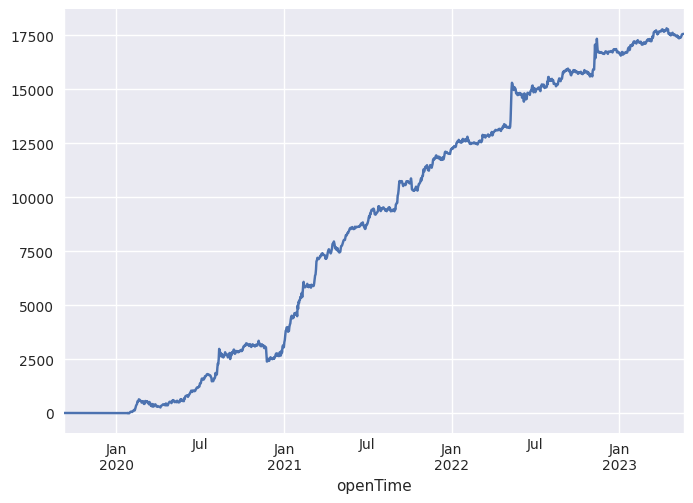

In [111]:
(pd.DataFrame(results) * [0.4,0.625]).mean(axis = 1).cumsum().plot()

In [34]:
results = {}

for name,params in strategies.items():
    tmp_result = {}
    for param in params:
        market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
        volume = df_data['quoteAssetVolume'].sort_index().rolling(param[0]).sum().fillna(0)
        volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
        GLOBAL_FILTER = market_filter & (volume_filter>0.5)
        GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()

        print(name,param)
        data = name.replace('_Reverse','').split('.')
        formula = '.'.join(data[1:])
        data = data[0]

        factor = calc_factors(calc_input_data(df_data,data),formula,params = param[1:])#[168,72,208,528]
        # factor = df_data['Open']/df_data['Close'] - 1
        # factor = factor.pow(2) * factor.apply(lambda x: np.sign(x))
        # factor = factor.rolling(424).kurt()
        factor = factor.sort_index().resample(FREQ).last()
        cond = GLOBAL_FILTER


        selected = 5



        rk = factor[cond].rank(axis = 1,ascending = '_Reverse' not in name,method = 'dense')
        
        select = rk.max(axis = 1) * selected * 0.01
        select = select.apply(lambda x:max(np.floor(x),3))

        long_signal = rk.copy()
        long_signal[:] = 0
        short_signal = long_signal.copy()

        # long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) & (df_data['Close'].pct_change()>0)] = 1 
        # short_signal[rk.le(select,axis = 0) & (df_data['Close'].pct_change()<0)] = -1 

        long_signal[rk.gt(rk.max(axis = 1) - select,axis = 0) ] = 1 
        short_signal[rk.le(select,axis = 0) ] = -1 

        # signal = (long_signal + short_signal).reindex(df_data['Close'].index).ffill().fillna(0)
        
        FEE = 4
        # long_result = fast_backtest(ret,long_signal,fee = FEE)#.sum(axis = 1)
        # short_result = fast_backtest(ret,short_signal,fee = FEE)#.sum(axis = 1)
        signal = rk.copy()
        signal[:] = 0


        signal[rk.gt(rk.max(axis = 1) - select,axis = 0)] = 1
        signal[rk.le(select,axis = 0)] = -1


        size = 10**4 / signal.abs().sum(axis = 1)
        size = signal/df_data['Close'].resample(FREQ).last().div(size,axis = 0)
        size = size.shift(1).reindex(df_data['Close'].index).ffill().fillna(0)


        cost = size.diff().abs() * df_data['Close'] * FEE *10**-4

        result = size.fillna(0) * df_data['Close'].diff() #- cost




        # size = 10**4/select/2 # / close * long_signal
        # size = 1/df_data['Close'].div(size,axis = 0) * (long_signal + short_signal)# * close


        tmp_result[f'{name}_{param}'] = result.sum(axis = 1)
        # break
    
    results[f'{name}'] = pd.DataFrame(tmp_result).sum(axis = 1)
    # break
    # break


High/Close.Pct_Change.Max.Skew_Reverse [168, 24, 48, 372]


/home/frank/.local/lib/python3.10/site-packages/pandas/core/window/rolling.py:579: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


High/Close.Pct_Change.Max.Skew_Reverse [72, 152, 112, 444]
High/Close.Pct_Change.Max.Skew_Reverse [168, 40, 136, 340]
High/Close.Pct_Change.Max.Skew_Reverse [168, 96, 72, 324]
High/Close.Pct_Change.Max.Skew_Reverse [24, 48, 72, 372]
High/Close.Pct_Change.Max.Skew_Reverse [24, 128, 120, 428]


In [24]:
compare = size.loc[datetime(2023,5,28)]
compare[compare != 0]

symbol
1000shibusdt    144910.734987
apeusdt           -386.279357
bnbusdt              4.064380
cfxusdt           3927.112787
gmtusdt           4699.248120
mtlusdt          -1177.911798
omgusdt          -1651.254954
stmxusdt       -290023.201856
Name: 2023-05-28 00:00:00, dtype: float64

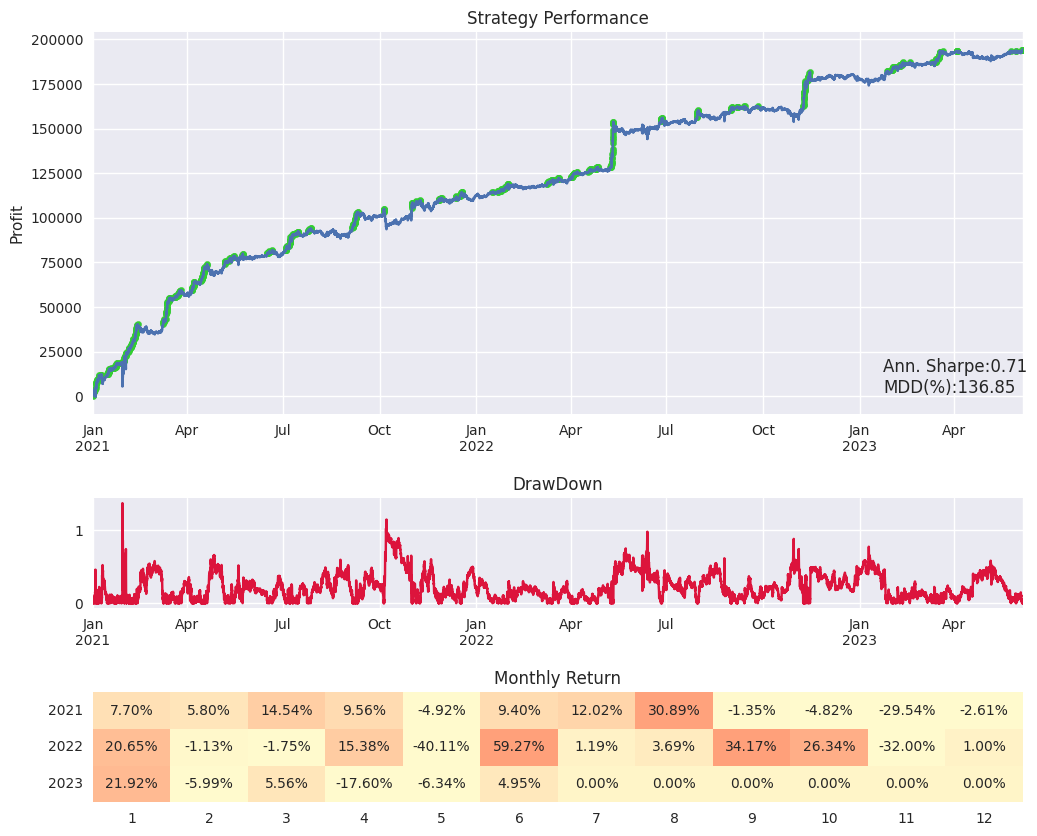

In [45]:
# (pd.DataFrame(results) * [0.4]).sum(axis = 1).cumsum().plot()
# (pd.DataFrame(results) * [1]).cumsum().plot()
show_return(pd.DataFrame(results).loc[datetime(2021,1,1):].mean(axis = 1))
# pd.DataFrame(results)

In [39]:
pd.DataFrame(results).mean() / pd.DataFrame(results).std() * (365) ** (0.5)

High/Close.Pct_Change.Max.Skew_Reverse    0.504374
dtype: float64

<AxesSubplot:xlabel='openTime'>

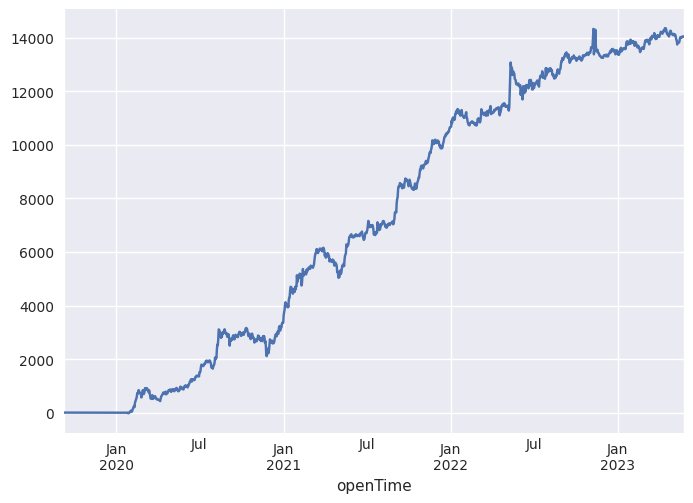

In [200]:
(pd.DataFrame(results) * [0.4]).sum(axis = 1).cumsum().plot()
# result.sum(axis=  1).cumsum().plot()